# Psuedoinverse Notebook

To run this notebook, you need the following files in the following directories:

- dataset/2pigs/lwp475/LWP475_Ws_14Nov2016_1.mat
- dataset/2pigs/lwp475/LWP475_DarkCount_14Nov2016.mat

In [1]:
import os
import torch
import scipy.io
import matplotlib.pyplot as plt
import cvxpy as cp
import seaborn as sns
from scipy.signal import medfilt, savgol_filter, wiener
from tqdm import tqdm
import numpy as np

os.chdir('..')
import data_processing.preprocessing as preprocessing
from config import left_cut, right_cut
from utils import beerlamb_multi

sns.set()

Let's run the pseudoinverse for optimization.
What differs compared to before:

- We run the pseudoinverse here with the assumption that $\Delta oxCCO + \Delta redCCO = 0$ (instead of $\leq 0.01$)
- We use the DarkCount Matlab File for normalization... not really sure about this, but gives more consistent results with what was observed for their optimization
- As reference we use reference_index = i = 0, this will be a flat spectrum interestingly.

For piglet LWP475, the Matlab File tells us this is the solution that they found in their paper.

![Matlab](./images/1.png)

They use the same assumption that $\Delta oxCCO + \Delta redCCO = 0$, however they have an approximation for the pathlength. This is why we cannot expect the same results, however we will see that we get a similar inferred concentration. Note that we will have different scaling of the time in the x-axis (plotted is $\times 10$ to what we will have as spectra were measured every 10 seconds).

Red is $HbO_2$, blue is $Hbb$ and yellow is diff_oxyCCO.


(214, 1) (214, 7) (214,) (214, 8806)


Text(0.5, 1.0, 'Diff Spectrogram')

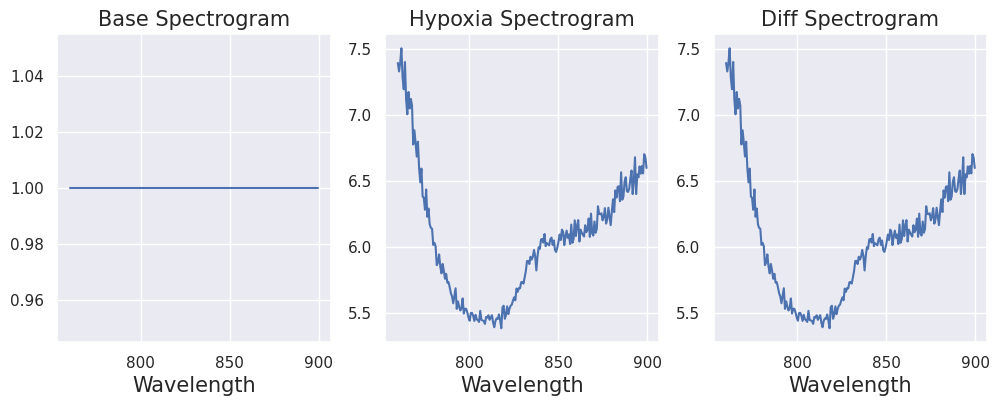

In [2]:
img = scipy.io.loadmat('dataset/2pigs/lwp475/LWP475_Ws_14Nov2016_1.mat')
img_darkcount = scipy.io.loadmat('dataset/2pigs/lwp475/LWP475_DarkCount_14Nov2016.mat')

### Visualising spectrograms with calibration
intensity1_c = []
intensity2_c = []

wavelengths = img['wavelengths'].astype(float)
white_full = img['refIntensity'].astype(float)
#dark_full = img['darkcount'].astype(float)
dark_full = img_darkcount['DarkCount'].astype(float)
spectr = img['spectralDataAll'].astype(float)

idx = (wavelengths >= left_cut) & (wavelengths <= right_cut)
wavelengths = wavelengths[idx]
spectr = spectr[idx.squeeze()]
dark_full = dark_full[idx.squeeze()]
white_full = white_full[idx.squeeze()]

# We wanna calibrate our HSI images w.r.t. white reference. Why? Because we saw by looking at the raw data that different
# wavelengths have different reflection from the white materila (i.e. reflecting 99% of light). So
# we calibrate our HSI images
print(white_full.shape, dark_full.shape, wavelengths.shape, spectr.shape)

fig, (ax, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))

reference_index = 0
spectr_1 = (spectr[:, reference_index] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
ax.plot(wavelengths, spectr_1)
#ax.plot(wavelengths, spectr)
ax.set_xlabel("Wavelength", fontsize=15)
ax.set_title("Base Spectrogram", fontsize=15)
#ax.set_ylim(-0.01, 0.3)

i = 7830  #7830
spectr_2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
ax1.plot(wavelengths, spectr_2)
ax1.set_xlabel("Wavelength", fontsize=15)
#ax1.plot(wavelengths, spectr[:,100])
#ax.set_xlabel("Wavelength", fontsize=20)
ax1.set_title("Hypoxia Spectrogram", fontsize=15)
#ax1.set_ylim(-0.01, 0.3)

spectr_1[spectr_1 <= 0] = 0.0001
spectr_2[spectr_2 <= 0] = 0.0001
spectr_3 = spectr_2 / spectr_1
ax2.plot(wavelengths, spectr_3)
ax2.set_xlabel("Wavelength", fontsize=15)
ax2.set_title("Diff Spectrogram", fontsize=15)

We now define the classical optimization function with cvxpy

In [3]:
#Define optimisation functions
molecules, x = preprocessing.read_molecules(left_cut, right_cut, wavelengths)
y_hbo2_f, y_hb_f, y_coxa, y_creda, _, _ = molecules
M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                            np.asarray(y_hb_f),
                            np.asarray(y_coxa),
                            np.asarray(y_creda))))

def optimisation(spectr1, spectr2, i):
    m = 4  # number of parameters (from 2 to 6)
    
    b = spectr2 / spectr1
    b = np.log(1 / np.asarray(b))  # see the writting above (we took log of I_R and there was also minus that went to the degree of the logarithm)
    X = cp.Variable(m)

    b1 = b
    X1 = X
    
    for b, X in [(b1, X1)]:  
        objective = cp.Minimize(cp.sum_squares(M @ X - b))
        constraints = [X[2]==-X[3]]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()

    return X1.value, b1

In [4]:
cut = 1000

ref_spectr = (spectr[:, 0] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
ref_spectr[ref_spectr <= 0] = 0.0001

spectra_list = []
coef_list = []
for i in tqdm(range(1, cut+1)):
    #if i not in [100,200,400,2000]: continue
    spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
    spectr2[spectr2 <= 0] = 0.0001

    coef_diff, spect_diff = optimisation(ref_spectr, spectr2, i)

    spectra_list.append(spect_diff)
    coef_list.append(coef_diff)

coef_list = np.vstack(coef_list)

100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 233.88it/s]


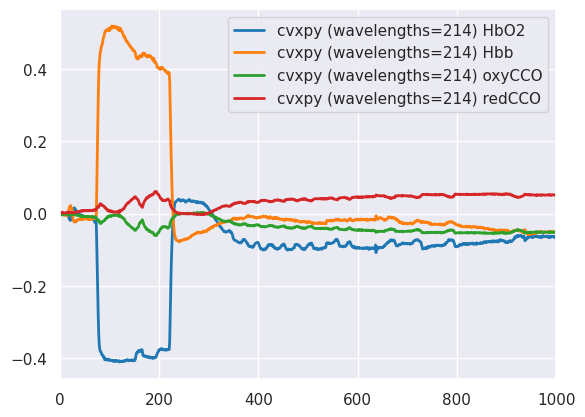

In [5]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
coef = ["HbO2", "Hbb", "oxyCCO", "redCCO"]
for i in range(4):
    plt.plot(coef_list[:, i], color=colors[i], label=f'cvxpy (wavelengths='+ str(ref_spectr.shape[0]) +') '+ coef[i], linewidth=2)

plt.xlim([0, 1000])
plt.legend()

We now change to pseudoinverse, using diff oxyCCO and rerun optimization. We can use diff because of our assumption

![img2](./images/2.png)

and build the pseudoinverse of the following linear system:

![img3](./images/3.png)


In [6]:
from scipy.linalg import pinv
M = np.transpose(np.vstack((np.asarray(y_hbo2_f),
                            np.asarray(y_hb_f),
                            np.asarray(y_coxa)-np.asarray(y_creda))))
M_coarse_pinv = pinv(M)

def optimisation_pinv(spectr1, spectr2, i):
    b = spectr2 / spectr1
    b = np.log(1 / np.asarray(b))  # see the writting above (we took log of I_R and there was also minus that went to the degree of the logarithm)
    return M_coarse_pinv @ b, b

M_coarse_pinv.shape

(3, 214)

In [7]:
spectra_list_pi = []
coef_list_pi = []
for i in tqdm(range(1, cut+1)):
    #if i not in [100,200,400,2000]: continue
    spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
    spectr2[spectr2 <= 0] = 0.0001

    coef_diff, spect_diff = optimisation_pinv(ref_spectr, spectr2, i)

    spectra_list_pi.append(spect_diff)
    coef_list_pi.append(coef_diff)

coef_list_pi = np.vstack(coef_list_pi)

100%|███████████████████████████████████| 1000/1000 [00:00<00:00, 110167.68it/s]


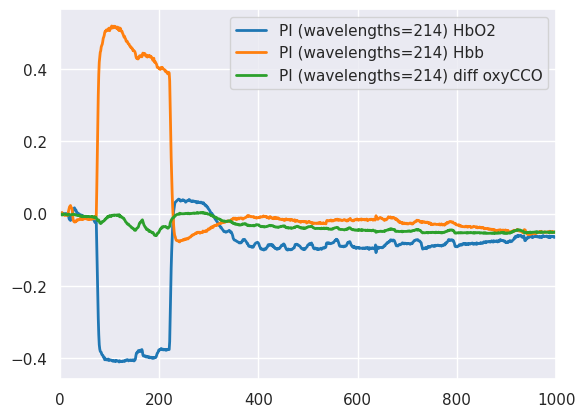

In [8]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
coef = ["HbO2", "Hbb", "diff oxyCCO"]
for i in range(3):
    plt.plot(coef_list[:, i], color=colors[i], label=f'PI (wavelengths='+ str(ref_spectr.shape[0]) +') '+ coef[i], linewidth=2)

plt.xlim([0, 1000])
plt.legend()

We qualitatively observe the same results. Quantitatively, it is also the same as we see below.

In [9]:
#coef_list_pi.vstack(-coef_list_pi[:,2])
coef_list_pi_with_redcco = np.insert(coef_list_pi, coef_list_pi.shape[1], -coef_list_pi[:,2], axis=1)
error = np.abs(coef_list_pi_with_redcco - coef_list)

In [10]:
sum(error)

array([1.35330522e-13, 1.12364436e-13, 6.85671544e-14, 6.27149835e-14])

To further speedup the problem, we can use less wavelengths. Let's try with less.

In [11]:
def run_PI_coarse(coarseness):
    M_coarse = np.transpose(np.vstack((np.asarray(y_hbo2_f[::coarseness]),
                            np.asarray(y_hb_f[::coarseness]),
                            np.asarray(y_coxa[::coarseness])-np.asarray(y_creda[::coarseness]))))
    M_coarse_pinv = pinv(M_coarse)
    
    def optimisation_coarse_pinv(spectr1, spectr2, i):
        b = spectr2[::coarseness] / spectr1[::coarseness]
        #print(b.shape)
        b = np.log(1 / np.asarray(b))  # see the writting above (we took log of I_R and there was also minus that went to the degree of the logarithm)
        return M_coarse_pinv @ b, b
    
    print("Pseudoinverse shape: " + str(M_coarse_pinv.shape))
    print("Wavelengths used: " + str(wavelengths[::coarseness]))
    
    spectra_list = []
    coef_list = []

    ref_spectr = (spectr[:, 0] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
    ref_spectr[ref_spectr <= 0] = 0.0001
    
    for i in tqdm(range(1, cut+1)):
        #if i not in [100,200,400,2000]: continue
        spectr2 = (spectr[:, i] - dark_full[:, 0]) / (white_full[:, 0] - dark_full[:, 0])
        spectr2[spectr2 <= 0] = 0.0001
    
        coef_diff, spect_diff = optimisation_coarse_pinv(ref_spectr, spectr2, i)
        spectra_list.append(spect_diff)
        coef_list.append(coef_diff)
        
    coef_list = np.vstack(coef_list)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    coef = ["HbO2", "Hbb", "diff oxyCCO"]
    
    for i in range(3):
        plt.plot(coef_list[:, i], color=colors[i], label=f'PI (wavelengths='+ str(M_coarse_pinv.shape[1]) +') '+ coef[i], linewidth=2)

    plt.xlim([0, 1000])
    plt.legend()

Pseudoinverse shape: (3, 36)
Wavelengths used: [760.01330323 763.99056152 767.9653603  771.93769081 775.90754428
 779.87491198 783.83978512 787.80215496 791.76201274 795.71934969
 799.67415706 803.6264261  807.57614804 811.52331412 815.46791558
 819.40994368 823.34938964 827.28624471 831.22050013 835.15214714
 839.08117699 843.00758091 846.93135015 850.85247595 854.77094955
 858.68676219 862.59990511 866.51036956 870.41814677 874.32322799
 878.22560445 882.12526741 886.0222081  889.91641776 893.80788764
 897.69660897]


100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 95368.44it/s]


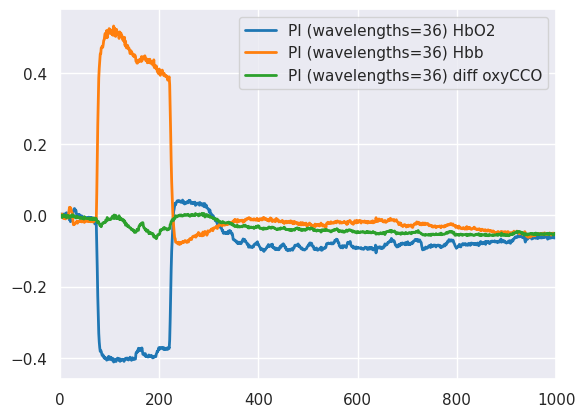

In [12]:
run_PI_coarse(6)

Even with less wavelengths, the inferred concentration is quite good

Pseudoinverse shape: (3, 11)
Wavelengths used: [760.01330323 773.26125096 786.4816437  799.67415706 812.83846666
 825.9742481  839.08117699 852.15892894 865.20717956 878.22560445
 891.21387924]


100%|███████████████████████████████████| 1000/1000 [00:00<00:00, 119621.94it/s]


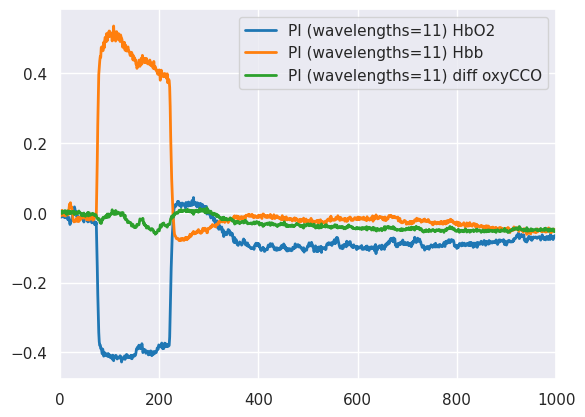

In [13]:
run_PI_coarse(20)

Pseudoinverse shape: (3, 5)
Wavelengths used: [760.01330323 793.08140558 825.9742481  858.68676219 891.21387924]


100%|███████████████████████████████████| 1000/1000 [00:00<00:00, 117149.51it/s]


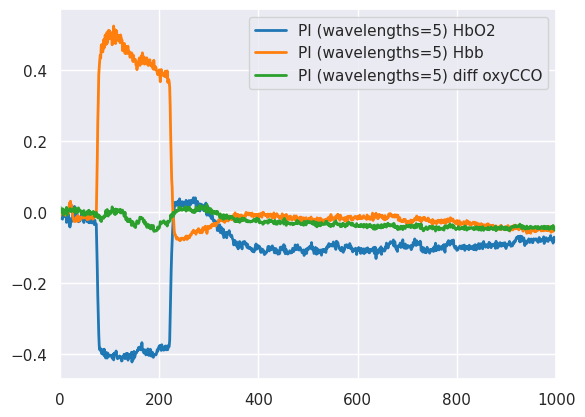

In [14]:
run_PI_coarse(50)

Pseudoinverse shape: (3, 3)
Wavelengths used: [760.01330323 825.9742481  891.21387924]


100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 71456.87it/s]


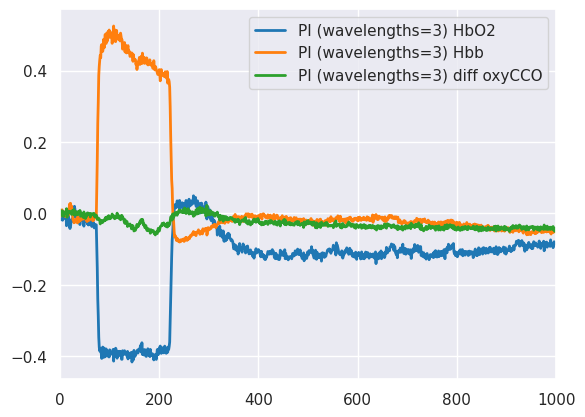

In [15]:
run_PI_coarse(100)

If we have less than 3 wavelengths, the solution is not unique anymore because we have more unknowns (3) than equations (observations at 2 wavelengths).

Pseudoinverse shape: (3, 2)
Wavelengths used: [760.01330323 858.68676219]


100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 81365.38it/s]


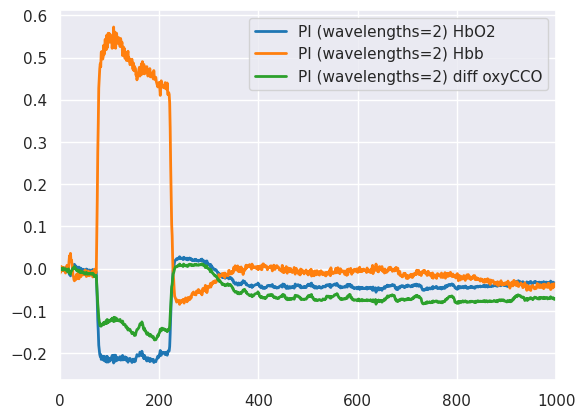

In [16]:
run_PI_coarse(150)